<a href="https://colab.research.google.com/github/sznajder/ON-Minicurso-de-ML-2022/blob/main/LSTM%26GRU_Keras_stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# LSTM or GRU implemented in Keras for Stock Prediction ( Time Series )



**Get NASDAQ data ( https://finance.yahoo.com/quote/GOOG/history/ ) loaded in a Pandas Dataframe**

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# mount Google Drive to access Data
!fusermount -u drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls "gdrive/My Drive/Colab Notebooks/"

# Get NASDAQ data ( https://finance.yahoo.com/quote/GOOG/history/ ) loaded in a Pandas Dataframe
stock_data = pd.read_csv("gdrive/My Drive/Colab Notebooks/GOOG.csv")
stock_data.info()

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
 Advanced_PDE_solving.ipynb
 AE_AnomalyDetectio_TFKeras.ipynb
 AE_MNIST_Keras.ipynb
 AE_PyTorch.ipynb
 Analysis_IN.ipynb
 analysis.ipynb
 AnomalyDetectionStudyToy.ipynb
'AutoDiff_numpy (1).ipynb'
 AutoDiff_numpy.ipynb
 AutodiffTutorial_LHeinrich_PyHep2020.ipynb
 Basic_PDE_solving.ipynb
 Bayesian_hyperparameter_optimization.ipynb
 BetheBlochEquation.ipynb
 Building_Perceptron_from_scratch.ipynb
 CAE_Denoising_Keras.ipynb
 CAE_PyTorch.ipynb
 CentralLimit.ipynb
 classifier_MLP_FelipeFreitas.ipynb
 Classifier_PyTorch_FelipeFreitas.ipynb
 CNN_MNIST_Keras_sigmoid.ipynb
 CNN_MNIST_Keras_softmax.ipynb
 CNN_PyTorch.ipynb
 CNPq_df.ipynb
 Convert_Delphes2CSV_FelipeFreitas.ipynb
 Convolution_padding_stride.ipynb
'Copy of AE_Keras.ipynb'
'Copy of convmixer'
'Copy of Image QGPT2.ipynb'
'Copy of mlp_image_classification'
'Copy of MLP_MNIST_Keras_new.ipynb'
 CreatJetGraphs_NetworkX_FelipeFreitas.ipynb
 D

**We will take the average of the low and high of the Google stock for the day and volume of the stocks traded for the day to predict the stock prices.**

         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-26  574.482788  577.664001  573.086609  575.519897  575.519897   
1  2014-09-29  570.184570  576.606934  569.606140  574.781921  574.781921   
2  2014-09-30  575.350403  578.262390  571.281555  575.779175  575.779175   
3  2014-10-01  574.432922  575.998596  565.457520  566.714111  566.714111   
4  2014-10-02  565.756714  570.344116  561.777649  568.519104  568.519104   

    Volume     average  
0  1443600  575.375305  
1  1282400  573.106537  
2  1621700  574.771972  
3  1445400  570.728058  
4  1178400  566.060882  
Input data shape: (1258, 2)


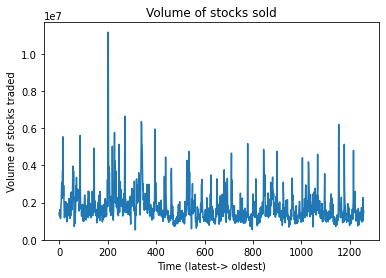

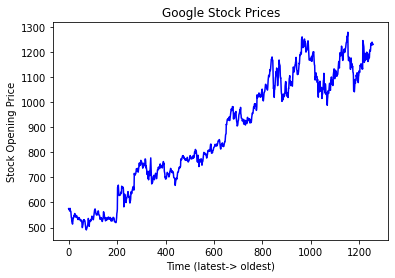

In [2]:
import math

# take the average of the low and high of the Google stock for the day
stock_data["average"] = (stock_data["High"] + stock_data["Low"])/2
print(stock_data.head())

# take the volume and average stock price as our input features and store it in input_data list
input_feature= stock_data.iloc[:,[6,7]].values
input_data = input_feature
print("Input data shape:",input_data.shape)

# plot the data for volume for the Google stocks traded for the day
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()


# plot the data for the average price for the day the Google stock
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

# Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])



**The input to every LSTM layer must be in a 3D format. The three dimensions of this input are:**
*   **Samples:** one sequence is one sample and a batch is comprised of one or more samples
*   **Time Steps:** one time step is one point of observation in the sample
*   **Features:** one feature is one observation at a time step

**This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value ( e.g. one sample or one feature ). The input layer of your LSTM network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. This is specifyied as a tuple to the input_shape argument.**




---


For more information see https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/




---





**We need to put the LSTM input data in the form (Volume of stocks traded, Average stock price). We also need to create a time series containing this data for past 50 days and the target variable that will be Google’s daily stock price.**

In [3]:
# Rescale data to [0,1] interval to make it easier to train the NN
#from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range = (0, 1))
#input_data = sc.fit_transform(input_data)

# Create the time series with lengh given by LOOKBACK
lookback= 30

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])


**The input data 3D format is (sample size, time steps, no. of input features).  In our case timesteps is given by LOOKBACK and the number of input features is 2 (volume of stocks traded and the average stock price).**

In [4]:
X, y= np.array(X), np.array(y)
#X_test = X[:test_size+lookback]
####### My mods to separate trainig from test data
#X_test = X[len(stock_data)-test_size-lookback:len(stock_data)]
X_test = X[len(stock_data)-lookback-test_size:len(stock_data)-lookback]
print("init=",len(stock_data)-lookback-test_size)
print("end=",len(stock_data)-lookback)
print("end=",len(stock_data))
X=X[0:len(stock_data)-lookback-test_size]
y=y[0:len(stock_data)-lookback-test_size]
#######
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)

# Print dimension of the training data and test data: No. of sample, time steps and no. of input features
print("Total number of days:",len(stock_data))
print("X=",X.shape)
print("X_test=",X_test.shape)
print("y=",y.shape[0])

init= 851
end= 1228
end= 1258
Total number of days: 1258
X= (851, 30, 2)
X_test= (376, 30, 2)
y= 851


**Build the LSTM**

In [5]:
from keras import Sequential
from keras.layers import Dense, LSTM , GRU

# define the LSTM architecture 
model = Sequential()
#model.add(LSTM(units=30, input_shape=(X.shape[1],2)))
model.add(GRU(units=30, input_shape=(X.shape[1],2)))
model.add(Dense(units=1,activation='linear'))
model.summary()

# compile 
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mean_squared_error"])
model.compile(optimizer='adam', loss='mean_squared_error')
# train the network
history = model.fit(X, y, epochs=10, batch_size=32 , verbose=1 , validation_split=0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30)                3060      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,091
Trainable params: 3,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 7s 22ms/step - loss: 0.0527 - val_loss: 0.0647
Epoch 2/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0450
Epoch 3/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0212
Epoch 4/10
22/22 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 5/10
22/22 [==============================] - 0s 6m

**Make predictions and plot performance**

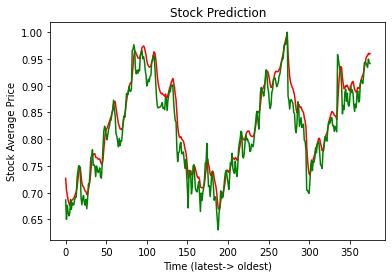

Text(0, 0.5, 'Loss')

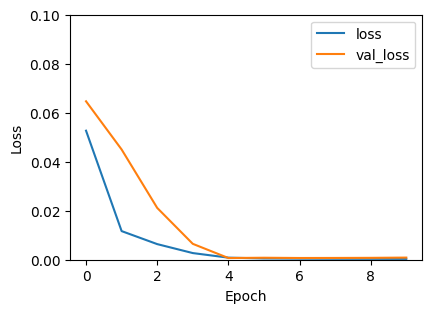

In [6]:
# make predictions
Y_test = model.predict(X_test)

# Remove normalization by going back to original range of stock values
#Y_test=sc.inverse_transform(Y_test)
#input_data=sc.inverse_transform(input_data)

# plot the predictions
plt.plot(Y_test, color= 'red')
plt.plot(X_test[:,-1,1], color='green')
plt.title("Stock Prediction")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

# plot performance
plt.style.use('default')
plt.figure(figsize=(10,7))

ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_ylim([0, 0.1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


